In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from dataloading.nvidia import NvidiaSpringTrainDataset, NvidiaTrainDataset, NvidiaValidationDataset
from network import PilotNet
from trainer import Trainer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")

trainset_spring = NvidiaSpringTrainDataset(root_path)
len(trainset_spring)

507960

In [11]:
trainset_autumn = NvidiaTrainDataset(root_path)
len(trainset_autumn)

689587

In [16]:
validset = NvidiaValidationDataset(root_path)
len(validset)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False,
                                         num_workers=32, pin_memory=True, persistent_workers=True)

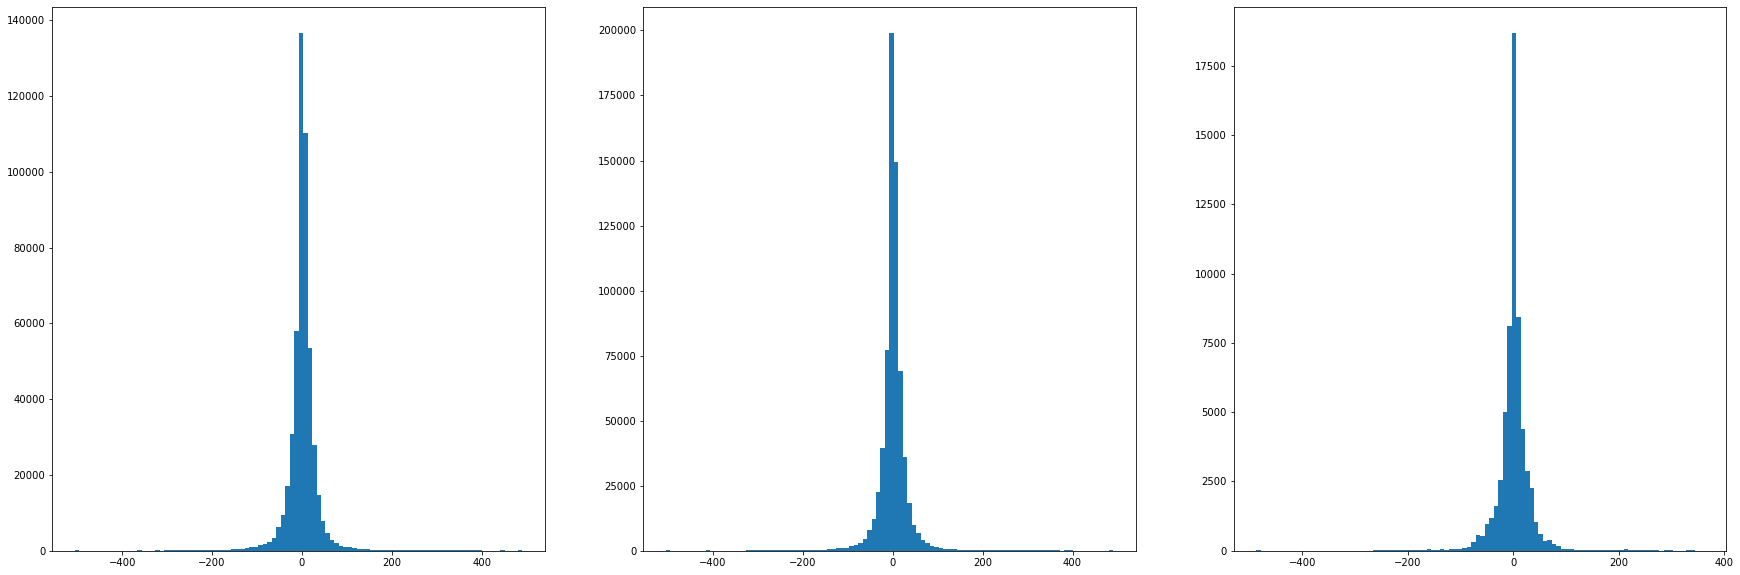

In [17]:

train_spring = trainset_spring.frames.steering_angle / np.pi * 180
train_autumn = trainset_autumn.frames.steering_angle / np.pi * 180
valid_steering = validset.frames.steering_angle / np.pi * 180

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.hist(train_spring, bins=100)
ax2.hist(train_autumn, bins=100)
ax3.hist(valid_steering, bins=100);

In [18]:
vahi1 = PilotNet()
vahi1.load_state_dict(torch.load(f"models/vahi-v1/best.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vahi1 = vahi1.to(device);

In [20]:
metrics = trainer.calculate_open_loop_metrics(vahi1, validloader, 30)
metrics

  0%|          | 0/971 [00:00<?, ?it/s]

{'MAE': 4.8961331939140305,
 'RMSE': 17.92842418467363,
 'Max': 532.748968172566,
 'Whiteness': 121.19639,
 'Expert whiteness': 26.501482161802812}

In [21]:
vahi2 = PilotNet()
vahi2.load_state_dict(torch.load(f"models/vahi-v2/best.pt"))
vahi2 = vahi2.to(device);

In [22]:
metrics = trainer.calculate_open_loop_metrics(vahi2, validloader, 30)
metrics

  0%|          | 0/971 [00:00<?, ?it/s]

{'MAE': 5.051123677372077,
 'RMSE': 14.307069147603231,
 'Max': 406.13261837456383,
 'Whiteness': 117.36306,
 'Expert whiteness': 26.501482161802812}

In [25]:
wide2 = PilotNet()
wide2.load_state_dict(torch.load(f"models/1-pilotnet-base/wide-v22/best.pt"))
wide2 = wide2.to(device)
metrics = trainer.calculate_open_loop_metrics(wide2, validloader, 30)
metrics

  0%|          | 0/971 [00:00<?, ?it/s]

{'MAE': 8.186433824694321,
 'RMSE': 31.70003145052848,
 'Max': 873.3217477387748,
 'Whiteness': 208.2767,
 'Expert whiteness': 26.501482161802812}

In [ ]:
def calculate_errors(model, dataloader, trainer):
    predictions = trainer.predict(model, dataloader)
    predicted_degrees = np.array(predictions) / np.pi * 180
    true_degrees = dataloader.dataset.frames.steering_angle.to_numpy() / np.pi * 180
    errors = true_degrees - predicted_degrees
    return errors, predicted_degrees, true_degrees

In [ ]:
errors, predicted_degrees, true_degrees = calculate_errors(wide2, validloader, trainer)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
ax1.hist(errors, bins=200)
ax1.set_xlim([-400, 400])
ax1.set_title("Errors")
ax2.hist(predicted_degrees, bins=200)
ax2.set_xlim([-400, 400])
ax2.set_title("Predicted degrees")
ax3.hist(true_degrees, bins=200)
ax3.set_xlim([-400, 400])
ax3.set_title("True degrees");

In [ ]:
errors, predicted_degrees, true_degrees = calculate_errors(vahi2, validloader, trainer)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
ax1.hist(errors, bins=200)
ax1.set_xlim([-400, 400])
ax1.set_title("Errors")
ax2.hist(predicted_degrees, bins=200)
ax2.set_xlim([-400, 400])
ax2.set_title("Predicted degrees")
ax3.hist(true_degrees, bins=200)
ax3.set_xlim([-400, 400])
ax3.set_title("True degrees");

In [ ]:
errors, predicted_degrees, true_degrees = calculate_errors(vahi1, validloader, trainer)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
ax1.hist(errors, bins=200)
ax1.set_xlim([-400, 400])
ax1.set_title("Errors")
ax2.hist(predicted_degrees, bins=200)
ax2.set_xlim([-400, 400])
ax2.set_title("Predicted degrees")
ax3.hist(true_degrees, bins=200)
ax3.set_xlim([-400, 400])
ax3.set_title("True degrees");